## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### In all tables, assume:
* "➊" represents a single hashtag
* "➋" represents a single URL
* "➌" represents a single mention of username (e.g. "@noah")

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.externals import joblib
from nltk.corpus import stopwords
from pprint import pprint
from random import choice, sample
from glob import glob
from os.path import basename, splitext
from string import punctuation

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.stats
import itertools
import enchant
import nltk
import json
import re

#### Set up some regex patterns

In [3]:
hashtags_pattern = re.compile(r'(\#[a-zA-Z0-9]+)')

In [4]:
urls_pattern = re.compile(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\xab\xbb\u201c\u201d\u2018\u2019]))')

In [5]:
at_mentions_pattern = re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z0-9_]+)')

#### Prepare English dictionary for language detection

In [6]:
english_dict = enchant.Dict("en_US")

#### Use NLTK's tokenizer instead of Scikit's

In [7]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Prepare for viewing long text in CSVs and ones with really big and small numbers

In [8]:
pd.set_option("max_colwidth", 1000)

In [9]:
pd.options.display.float_format = "{:.4f}".format

#### Load the two data files
#### Only use tweets with at least 50% English words
#### Also, make the mentions of usernames, URLs, and hashtags generic

In [10]:
def load_data(filename, threshold=0.5):
    data = [(hashtags_pattern.sub("➊", 
             urls_pattern.sub("➋", 
             at_mentions_pattern.sub("➌", 
             t["tweet_data"]["full_text"])))
             .replace("\u2018", "'")
             .replace("\u2019", "'")
             .replace("\u201c", "\"")
             .replace("\u201d", "\"")
             .replace("&quot;", "\"")
             .replace("&amp;", "&")
             .replace("&gt;", ">")
             .replace("&lt;", "<")) 
            for t in json.load(open(filename)) 
            if t["tweet_data"]["user"]["lang"] == "en" 
            and t["reply"]["user"]["lang"] == "en"]
    new_data = []
    for tweet in data:
        tokens = tokenizer.tokenize(tweet)
        english_tokens = [english_dict.check(token) for token in tokens]
        percent_english_words = sum(english_tokens)/len(english_tokens)
        if percent_english_words >= threshold:
            new_data.append(tweet)
    return new_data

In [11]:
subtweets_data = load_data("../data/other_data/subtweets.json")

In [12]:
non_subtweets_data = load_data("../data/other_data/non_subtweets.json")

#### Show examples

In [13]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
This is a pivotal moment to see if I am an adult or still a petty teenager and I'm leaning towards adult


In [14]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
This is DeRozan's best game in a while.


#### Find the length of the smaller dataset

In [15]:
smallest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Cut both down to be the same length

In [16]:
subtweets_data = subtweets_data[:smallest_length]

In [17]:
non_subtweets_data = non_subtweets_data[:smallest_length]

In [18]:
print("Smallest dataset length: {}".format(len(subtweets_data)))

Smallest dataset length: 7837


#### Prepare data for training

In [19]:
subtweets_data = [(tweet, "subtweet") for tweet in subtweets_data]

In [20]:
non_subtweets_data = [(tweet, "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [21]:
training_data = subtweets_data + non_subtweets_data

#### Create custom stop words to include generic usernames, URLs, and hashtags, as well as common English first names

In [22]:
names_lower = set([name.lower() for name in open("../data/other_data/first_names.txt").read().split("\n")])

In [23]:
generic_tokens = {"➊", "➋", "➌"}

In [24]:
stop_words = text.ENGLISH_STOP_WORDS | names_lower | generic_tokens

#### Build the pipeline

In [25]:
sentiment_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   ngram_range=(1, 3), 
                                   stop_words=stop_words)),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [26]:
def confusion_matrices(training_data, num_folds=10):
    text_training_data = np.array([row[0] for row in training_data])
    class_training_data = np.array([row[1] for row in training_data])
    kf = KFold(n_splits=num_folds, random_state=42, shuffle=True)
    
    cnf_matrix_test = np.zeros((2, 2), dtype=int)
    cnf_matrix_train = np.zeros((2, 2), dtype=int)
    
    test_reports = []
    train_reports = []
    for i, (train_index, test_index) in enumerate(kf.split(text_training_data)):

        text_train, text_test = text_training_data[train_index], text_training_data[test_index]
        class_train, class_test = class_training_data[train_index], class_training_data[test_index]

        sentiment_pipeline.fit(text_train, class_train)
        
        predictions_test = sentiment_pipeline.predict(text_test)
        predictions_train = sentiment_pipeline.predict(text_train)

        cnf_matrix_test += confusion_matrix(class_test, predictions_test)
        cnf_matrix_train += confusion_matrix(class_train, predictions_train)

        print("Test Data Iteration {}:".format(i+1))
        
        test_report = classification_report(class_test, predictions_test, digits=4)
        test_reports.append(test_report)
        print(test_report)
        
        print(("Test Data Null Accuracy: {:.4f}\n"
               .format(max(pd.value_counts(pd.Series(class_test)))/float(len(class_test)))))
        print("="*53)
        
        print("Train Data Iteration {}:".format(i+1))
        
        train_report = classification_report(class_train, predictions_train, digits=4)
        train_reports.append(train_report)
        print(train_report)
        
        print(("Train Data Null Accuracy: {:.4f}\n"
               .format(max(pd.value_counts(pd.Series(class_train)))/float(len(class_train)))))
        print("="*53)
        
    def reports_mean(reports):
        reports_lists_of_strings = [report.split("\n") for report in reports]
        reports = [[[float(e) for e in report_string[2][16:].split()],
                    [float(e) for e in report_string[3][16:].split()],
                    [float(e) for e in report_string[5][16:].split()]]
                   for report_string in reports_lists_of_strings]
        mean_list = np.mean(np.array(reports), axis=0).tolist()
        print("              precision    recall  f1-score   support")
        print()
        print("non-subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[0][0], 
                                                                                 mean_list[0][1], 
                                                                                 mean_list[0][2], 
                                                                                 int(mean_list[0][3])))
        print("    subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[1][0], 
                                                                                 mean_list[1][1], 
                                                                                 mean_list[1][2], 
                                                                                 int(mean_list[1][3])))
        print()
        print(" avg / total     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[2][0], 
                                                                                 mean_list[2][1], 
                                                                                 mean_list[2][2], 
                                                                                 int(mean_list[2][3])))
        print()
        print("="*53)
    
    print("Test Data Averages Across All Folds:")
    reports_mean(test_reports)
    print("Train Data Averages Across All Folds:")
    reports_mean(train_reports)
    return {"Test": cnf_matrix_test, "Train": cnf_matrix_train}

In [27]:
%%time
cnf_matrices = confusion_matrices(training_data)
cnf_matrix_test = cnf_matrices["Test"]
cnf_matrix_train = cnf_matrices["Train"]

Test Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.7338    0.6431    0.6855       793
    subtweet     0.6758    0.7613    0.7160       775

 avg / total     0.7052    0.7015    0.7006      1568

Test Data Null Accuracy: 0.5057

Train Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.9907    0.9806    0.9856      7044
    subtweet     0.9808    0.9908    0.9858      7062

 avg / total     0.9857    0.9857    0.9857     14106

Train Data Null Accuracy: 0.5006

Test Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.6940    0.6324    0.6618       789
    subtweet     0.6584    0.7176    0.6867       779

 avg / total     0.6763    0.6747    0.6742      1568

Test Data Null Accuracy: 0.5032

Train Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.9908    0.9786    0.9847      7048
    subtweet     0.9789    0.9909    0.9

#### See the most informative features
[How does "MultinomialNB.coef_" work?](https://stackoverflow.com/a/29915740/6147528)

In [28]:
def most_informative_features(pipeline, n=10000):
    vectorizer = pipeline.named_steps["vectorizer"]
    classifier = pipeline.named_steps["classifier"]
    
    class_labels = classifier.classes_
    
    feature_names = vectorizer.get_feature_names()
    
    top_n_class_1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    top_n_class_2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    return {class_labels[0]: pd.DataFrame({"Log Probability": [tup[0] for tup in top_n_class_1], 
                                           "Feature": [tup[1] for tup in top_n_class_1]}), 
            class_labels[1]: pd.DataFrame({"Log Probability": [tup[0] for tup in reversed(top_n_class_2)],
                                           "Feature": [tup[1] for tup in reversed(top_n_class_2)]})}

In [29]:
%%time
most_informative_features_all = most_informative_features(sentiment_pipeline)

CPU times: user 1.3 s, sys: 27.8 ms, total: 1.33 s
Wall time: 1.32 s


In [30]:
most_informative_features_non_subtweet = most_informative_features_all["non-subtweet"]

In [31]:
most_informative_features_subtweet = most_informative_features_all["subtweet"]

In [32]:
final_features = most_informative_features_non_subtweet.join(most_informative_features_subtweet, 
                                                             lsuffix=" (Non-subtweet)", 
                                                             rsuffix=" (Subtweet)")
final_features.to_csv("../data/other_data/most_informative_features.csv")
final_features.head(25)

,Feature (Non-subtweet),Log Probability (Non-subtweet),Feature (Subtweet),Log Probability (Subtweet)
0,! ! &,-12.6618,.,-7.5300
1,! ! (,-12.6618,",",-7.9193
2,! ! ),-12.6618,"""",-8.0928
3,! ! .,-12.6618,people,-8.3903
4,! ! 100,-12.6618,?,-8.4594
5,! ! 15,-12.6618,don't,-8.5588
6,! ! 3,-12.6618,like,-8.5889
7,! ! 5,-12.6618,just,-8.6754
8,! ! 8am,-12.6618,i'm,-8.6969
9,! ! :),-12.6618,!,-8.9031


#### Define function for visualizing confusion matrices

In [33]:
def plot_confusion_matrix(cm, classes=["non-subtweet", "subtweet"], 
                          title="Confusion Matrix", cmap=plt.cm.Purples):
    
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    plt.title(title, size=18)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{} ({:.0%})".format(cm[i, j], cm_normalized[i, j]),
                horizontalalignment="center", size=16,
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    
    plt.ylabel("True label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

#### Show the matrices

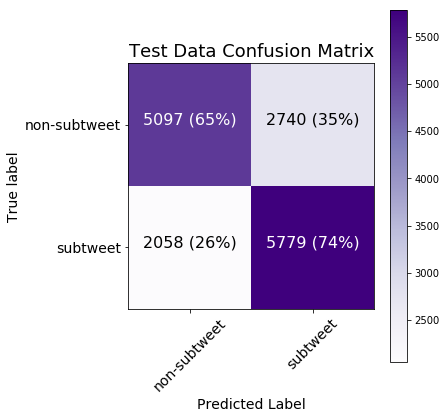

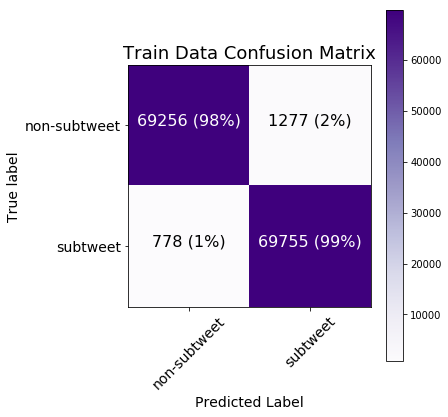

In [34]:
np.set_printoptions(precision=2)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_test, title="Test Data Confusion Matrix")

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_train, title="Train Data Confusion Matrix")

plt.show()

#### Update matplotlib style

In [35]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [36]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [37]:
def process_tweets_for_testing(filenames):
    dataframes = {}
    for filename in filenames:
        username = splitext(basename(filename))[0][:-7]
        dataframes[username] = {}
        
        user_df = pd.read_csv(filename).dropna()
        user_df["Text"] = user_df["Text"].str.replace(hashtags_pattern, "➊")
        user_df["Text"] = user_df["Text"].str.replace(urls_pattern, "➋")
        user_df["Text"] = user_df["Text"].str.replace(at_mentions_pattern, "➌")
        user_df["Text"] = user_df["Text"].str.replace("\u2018", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u2019", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u201c", "\"")
        user_df["Text"] = user_df["Text"].str.replace("\u201d", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&quot;", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&amp;", "&")
        user_df["Text"] = user_df["Text"].str.replace("&gt;", ">")
        user_df["Text"] = user_df["Text"].str.replace("&lt;", "<")
        
        predictions = sentiment_pipeline.predict_proba(user_df["Text"])[:, 1].tolist()
        user_df["SubtweetProbability"] = predictions

        dataframes[username]["all"] = user_df
        
        scores = user_df[["SubtweetProbability"]].rename(columns={"SubtweetProbability": username})
        
        dataframes[username]["scores"] = scores
        dataframes[username]["stats"] = scores.describe()
        
    return dataframes

#### Load the CSV files

In [38]:
filenames = glob("../data/data_for_testing/friends_data/*.csv")

In [39]:
%%time
dataframes = process_tweets_for_testing(filenames)

CPU times: user 8.76 s, sys: 122 ms, total: 8.88 s
Wall time: 9.07 s


#### Show a random table

In [40]:
chosen_username = choice(list(dataframes.keys()))
dataframes[chosen_username]["all"].sort_values(by="SubtweetProbability", ascending=False).head(5)

,Text,Date,Favorites,Retweets,Tweet ID,SubtweetProbability
462,ppl saying zionist shit on the internet really fucks w my high,2017-07-17 02:27:07,11,0,886834632125288448,0.8244
15,i hate seeing shitty straight people yelling at their kids in public like why did you breed,2018-03-21 12:49:00,24,3,976500935437496320,0.8140
392,"some1 replied to my tweet about cis ppl making xcuses 4 not dating trans ppl w ""bc they have a fucking cock""",2017-08-01 19:08:46,10,0,892522524361322496,0.8044
563,"cw my shit mental health: u know shit is f'd up when ur lookin @ a meme abt dying of old age and yr like ""this meme is actually optimistic""",2017-06-20 22:12:12,2,1,877348396029358080,0.7965
477,I FUCKING LOVE QUEER PEOPLE,2017-07-09 21:20:04,19,1,884220643226644480,0.7938


#### Prepare statistics on tweets

In [41]:
tests_df = pd.concat([df_dict["scores"] for df_dict in dataframes.values()], ignore_index=True)

In [42]:
tests_df.describe()

,adhaardesai,akrapf96,generatedtext,gothodile,juliaeberry,kayleesue,keithohara,metalgarurumonz,noahsegalgould,paul_hembree,pumpkinheadgal,scorpiodisaster,whoisleormiller,zoeterhune
count,621.0000,2640.0000,2066.0000,3488.0000,4356.0000,1939.0000,1169.0000,638.0000,2814.0000,445.0000,772.0000,5364.0000,853.0000,1467.0000
mean,0.4996,0.5086,0.5438,0.5270,0.5187,0.4976,0.4388,0.5408,0.5107,0.4496,0.5375,0.5037,0.5399,0.5355
std,0.1059,0.1150,0.1136,0.1086,0.1023,0.1106,0.0981,0.1152,0.1089,0.0981,0.1168,0.1129,0.1131,0.1029
min,0.1981,0.0953,0.1266,0.1626,0.1522,0.0566,0.1497,0.1983,0.1506,0.1353,0.0750,0.0618,0.1781,0.1077
25%,0.4291,0.4304,0.4669,0.4538,0.4492,0.4260,0.3733,0.4700,0.4368,0.3896,0.4645,0.4279,0.4677,0.4708
50%,0.4971,0.5037,0.5417,0.5217,0.5180,0.4981,0.4379,0.5327,0.5061,0.4596,0.5351,0.4986,0.5410,0.5335
75%,0.5670,0.5847,0.6213,0.5982,0.5843,0.5669,0.5016,0.6190,0.5811,0.5117,0.6138,0.5782,0.6189,0.6028
max,0.8457,0.8579,0.8497,0.8749,0.8674,0.8766,0.8157,0.8498,0.8972,0.7563,0.8447,0.9091,0.8244,0.8674


#### Plot a histogram with three random users

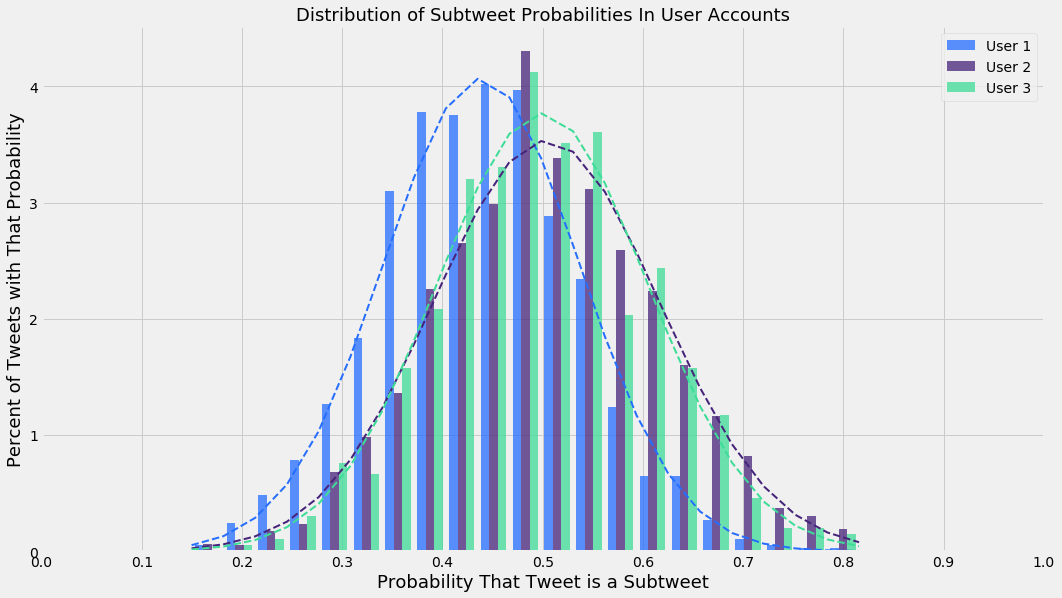

In [43]:
random_choices = sample(list(dataframes.values()), 3)
scores = [df_dict["scores"][df_dict["scores"].columns[0]].tolist() 
          for df_dict in random_choices]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(scores, 
                           bins="scott",
                           color=["#256EFF", "#46237A", "#3DDC97"],
                           density=True, 
                           label=["User 1", "User 2", "User 3"],
                           alpha=0.75)

stats = [df_dict["stats"][df_dict["stats"].columns[0]].tolist() 
         for df_dict in random_choices]

line_1 = scipy.stats.norm.pdf(bins, stats[0][1], stats[0][2])
ax.plot(bins, line_1, "--", color="#256EFF", linewidth=2)

line_2 = scipy.stats.norm.pdf(bins, stats[1][1], stats[1][2])
ax.plot(bins, line_2, "--", color="#46237A", linewidth=2)

line_3 = scipy.stats.norm.pdf(bins, stats[2][1], stats[2][2])
ax.plot(bins, line_3, "--", color="#3DDC97", linewidth=2)

ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Plot a histogram with all of them
#### First, get some statistics

In [44]:
new_tests_df = pd.concat([df_dict["scores"].rename(columns={df_dict["scores"].columns[0]:"SubtweetProbability"})
                          for df_dict in dataframes.values()], ignore_index=True)

new_tests_df_stats = new_tests_df.describe()

#### Then view them

In [45]:
new_tests_df_stats

,SubtweetProbability
count,28632.0000
mean,0.5133
std,0.1115
min,0.0566
25%,0.4385
50%,0.5093
75%,0.5860
max,0.9091


#### Now plot

No handles with labels found to put in legend.


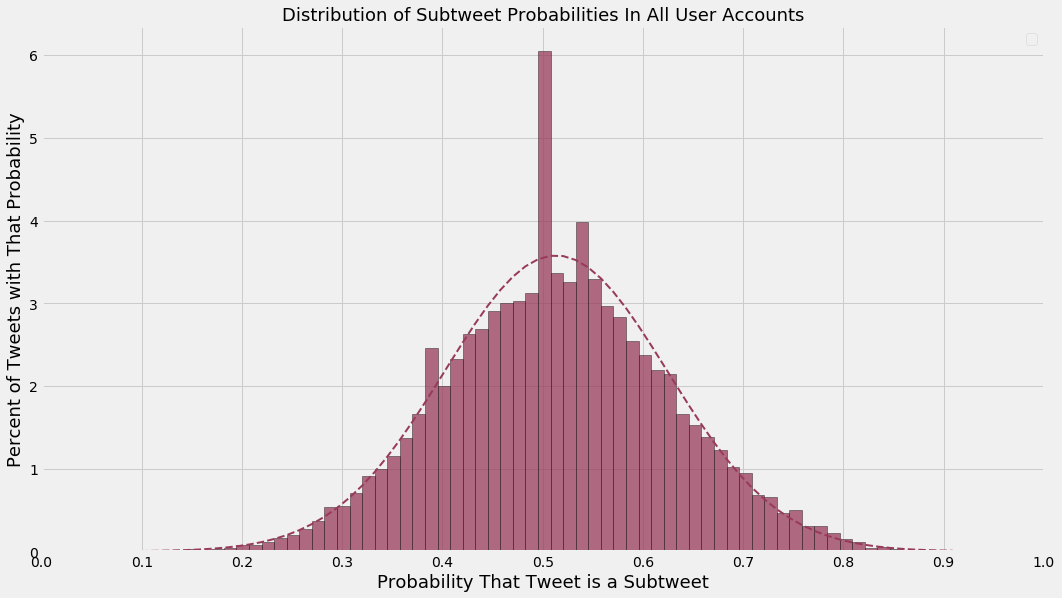

In [46]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(new_tests_df["SubtweetProbability"].tolist(), 
                           bins="scott",
                           color="#983B59",
                           edgecolor="black", 
                           density=True, 
                           alpha=0.75)

line = scipy.stats.norm.pdf(bins, new_tests_df_stats["SubtweetProbability"][1], 
                              new_tests_df_stats["SubtweetProbability"][2])

ax.plot(bins, line, "--", color="#983B59", linewidth=2)


ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In All User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Statisitics on training data

#### Remove mentions of usernames for these statistics

In [47]:
training_data = [(tweet[0]
                  .replace("➊", "")
                  .replace("➋", "")
                  .replace("➌", "")) for tweet in training_data]

#### Lengths

In [48]:
length_data = [len(tweet) for tweet in training_data]

In [49]:
length_data_for_stats = pd.DataFrame({"Length": length_data, "Tweet": training_data})

In [50]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] <= 280]  

In [51]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] >= 5]

In [52]:
length_data = length_data_for_stats.Length.tolist()

#### Top 5 longest tweets

In [53]:
length_data_for_stats.sort_values(by="Length", ascending=False).head()

,Length,Tweet
8887,281,"This Tweet does not endorse the use of Nazi Symbols in any form! I think the image which has been published on social media and MSM is a day or two old. It conjures up strong emotions for many people, My question is simple what meaning do you think is being conveyed by the image?"
2198,281,"I need to learn how to do this. I ask ""how can I help"" a lot because I genuinely want to make things better for friends , but this *can* put a burden back upon those who are suffering. Sometimes it may be best to just have exuberant and fearless compassion the same way a pet does"
1531,281,hi! I'm not normally v personal like this and I probably won't be at least for a v long time but I thought I'd share this \nwhile I was scrolling on Twitter today I had like a sudden impulse to just dump all my thoughts about what id been reading and seeing and so far it actually-
10533,281,"Some people are undecided about testing on animals. Understandable. There's so much propaganda and secrecy about it. Here's a quick test though, & you're answer should tell you. What would you do if some man came to your house & squirted disinfectant in your beautiful dog's eyes?"
10521,281,"Enthralled by Raja Shiv Chhatrapati, a well mounted magnum opus on life of the Maratha warrior at Red Fort. Vividly brought out his philosophies, struggles, inspiration from mother Jijayee & penchant for gender equality through well conceived music, dance & dialogues. A must see!"


#### Top 5 shortest tweets

In [54]:
length_data_for_stats.sort_values(by="Length", ascending=True).head()

,Length,Tweet
7699,1,A
3473,2,no
5896,2,uh
6676,2,i-
2038,2,Ha


#### Tweet length statistics

In [55]:
length_data_for_stats.describe()

,Length
count,15674.0000
mean,106.8089
std,73.8680
min,1.0000
25%,48.0000
50%,87.0000
75%,150.0000
max,281.0000


#### Punctuation

In [56]:
punctuation_data = [len(set(punctuation).intersection(set(tweet))) for tweet in training_data]

In [57]:
punctuation_data_for_stats = pd.DataFrame({"Punctuation": punctuation_data, "Tweet": training_data})

#### Top 5 most punctuated tweets

In [58]:
punctuation_data_for_stats.sort_values(by="Punctuation", ascending=False).head()

,Punctuation,Tweet
8957,11,"Going to go ahead and crown myself the absolute emperor of finding things on menus that sound interesting, deciding I would like to try them, then being told ""I'm sorry sir, that's actually not available...""\n\n[ then why the @#$% is it ON YOUR MENUUUUUUUU-- ]"
6725,9,"4-yo: DADDEEEEEE!? LET'S PLAY!\nMe: Ok, baby. \n4yo: you play w/ her. put a dress on her DADDEEEEEE. \nMe: Ok. *puts doll in dollhouse*\n4yo: SHE DOESN'T GO THERE!!"
11718,9,"Self-employed people: have you ever turned to social media to call out a client who is many weeks/months delinquent on a payment? \n(Obviously, you're probably burning a bridge with that move, but if they don't pay...)"
13365,9,"Billboard Hot 100: (-3) Tell Me You Love Me, [19 weeks]. *peak: *"
11845,9,"Tucker Carlson Tonight & TFW you're asking about America\nbut you're scolded it's really about Israel ...\n \nTucker: ""What is the American national security interest ... in Syria?""\n\nSen. Wicker(R): ""Well, if you care about Israel ..."" \n\nThat was the exact question & answer\nShocking"


#### Tweets punctuation statistics

In [59]:
punctuation_data_for_stats.describe()

,Punctuation
count,15674.0000
mean,1.9168
std,1.5787
min,0.0000
25%,1.0000
50%,2.0000
75%,3.0000
max,11.0000


#### Stop words

In [60]:
stop_words_data = [len(set(stopwords.words("english")).intersection(set(tweet.lower()))) 
                   for tweet in training_data]

In [61]:
stop_words_data_for_stats = pd.DataFrame({"Stop words": stop_words_data, "Tweet": training_data})

#### Top 5 tweets with most stop words

In [62]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=False).head()

,Stop words,Tweet
0,8,"I don't yet have adequate words to do so, but someday I wanna write about the beautiful dance which happens in Google docs between a writer & a good editor working simultaneously towards a deadline. When it's working, it's a beautiful dance—though no one really sees it."
9063,8,Honestly yea i fucked up but all of you are trash asf and your opinions mean nothing to me because mother fucker i can fix shit but yall are to close minded to see.
9035,8,The role of DAG Rod Rosenstein will be an Oscar winner in the future film about the Trump presidency. I'd like the story of the first few months to be told through the eyes of the bewildered Sean Spicer.
9038,8,"Done watching 'Hacksaw Ridge'. If there's one thing I learned from that movie, it is simply, Have Faith in God."
9039,8,I feel people who can't celebrate or at the very least respect Cardi B's success have never watched the grind from the ground up. They can't understand that her work ethic has gotten her where she is now. You don't have to stand for what's she's about but she's worked for it


#### Top 5 tweets with fewest stop words

In [63]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=True).head()

,Stop words,Tweet
3632,0,...
8290,0,24
11925,0,FUCK
10940,0,78 ... !
1796,0,fuck u


#### Tweets stop words statistics

In [64]:
stop_words_data_for_stats.describe()

,Stop words
count,15674.0000
mean,7.1515
std,1.3116
min,0.0000
25%,7.0000
50%,8.0000
75%,8.0000
max,8.0000


#### Unique words

In [65]:
unique_words_data = [len(set(tokenizer.tokenize(tweet))) for tweet in training_data]

In [66]:
unique_words_data_for_stats = pd.DataFrame({"Unique words": unique_words_data, "Tweet": training_data})

In [67]:
# unique_words_data_for_stats = unique_words_data_for_stats[unique_words_data_for_stats["Unique words"] >= 2]

In [68]:
unique_words_data = unique_words_data_for_stats["Unique words"].tolist()

#### Top 5 tweets with most unique words

In [69]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=False).head()

,Tweet,Unique words
13936,"GIVE AWAY!\n\nThe rules are really easy, all you have to do is :\n1. Must be following me (i check) \n2. RT and fav this tweet\n3. tag your mutuals/anyone\n4. only 1 winner! \n5. i ship worldwide;) \n\nit ends in 8th May 2018 or when this tweet hit 2k RT and like!\n\nGood luck! ❤",59
4881,"got into a tepid back nd forth w/ a uknowwhoAJ+columnist bc i said they steal their ""hot takes"" from blk twitter & alike. wallahi my bdeshi ass did not sign up 4 this app to be called asinine by a 30yrold pakistani whos whole politics is Post Colonial Memes for Oriental Minded T-",57
7013,"Crazy how wrong u can be about someone. A girl I graduated w/ was always doing drugs& got pregnant at 16. I assumed she'd end up being a loser but it turn out she now has 4 beautiful kids& is making over $4,500/month just off of child support payments from the 3 different dads",57
4992,"Got into an argument w/ someone I went to HS w/ & I would js like to repeat again tht I cannot wait to stunt on all the ppl who were bitches to me in HS @ our reunion. Catch me rollin up w/ my sexy ass gf, a nice car, a bomb body & the career of my dreams as a big fuck u to them",55
11542,"Thought I'd bring this back... and no, I'm not talking about myself here. I wish just once I'd be so bored with my life that I'd find the time to bash people/celebs I don't like.. I mean if I despise someone THAT much, why still watch his/her every move? 🤦‍♀️",55


#### Top 5 tweets with fewest unique words

In [70]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=True).head()

,Tweet,Unique words
6106,Annoying,1
2525,Bitch,1
12087,Chandler,1
14559,Yes yes yes yes yes yes,1
14442,Hello\n,1


#### Tweets unique words statistics

In [71]:
unique_words_data_for_stats.describe()

,Unique words
count,15674.0000
mean,19.2412
std,11.9298
min,1.0000
25%,10.0000
50%,17.0000
75%,27.0000
max,59.0000


#### Plot them

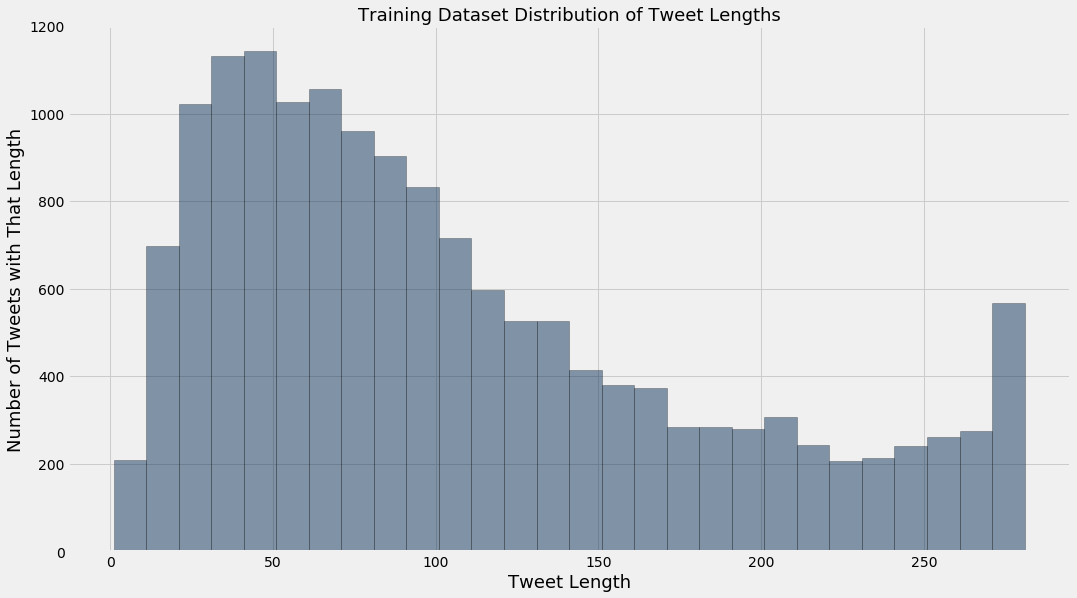

In [72]:
length_mean = length_data_for_stats.describe().Length[1]
length_std = length_data_for_stats.describe().Length[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(length_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#12355b", 
                           alpha=0.5)

# length_line = scipy.stats.norm.pdf(bins, length_mean, length_std)
# ax.plot(bins, length_line, "--", linewidth=3, color="#415d7b")

ax.set_title("Training Dataset Distribution of Tweet Lengths", fontsize=18)
ax.set_xlabel("Tweet Length", fontsize=18);
ax.set_ylabel("Number of Tweets with That Length", fontsize=18);

plt.show()

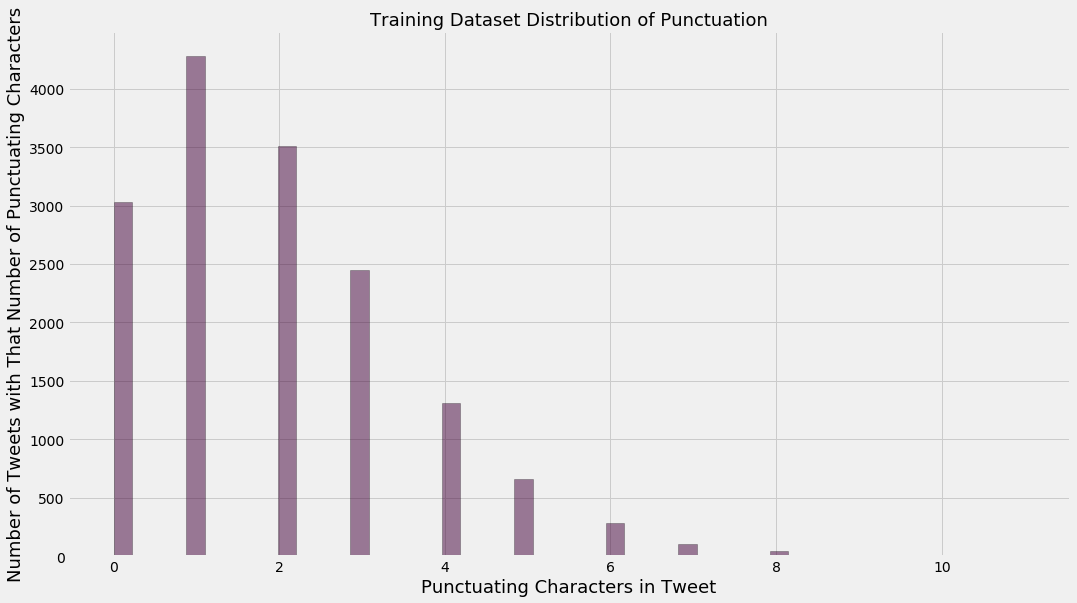

In [73]:
punctuation_mean = punctuation_data_for_stats.describe().Punctuation[1]
punctuation_std = punctuation_data_for_stats.describe().Punctuation[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(punctuation_data, 
                           bins="scott",
                           edgecolor="black", 
                           # density=True, 
                           color="#420039",
                           alpha=0.5)

# punctution_line = scipy.stats.norm.pdf(bins, punctuation_mean, punctuation_std)
# ax.plot(bins, punctution_line, "--", linewidth=3, color="#673260")

ax.set_title("Training Dataset Distribution of Punctuation", fontsize=18)
ax.set_xlabel("Punctuating Characters in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Punctuating Characters", fontsize=18)

plt.show()

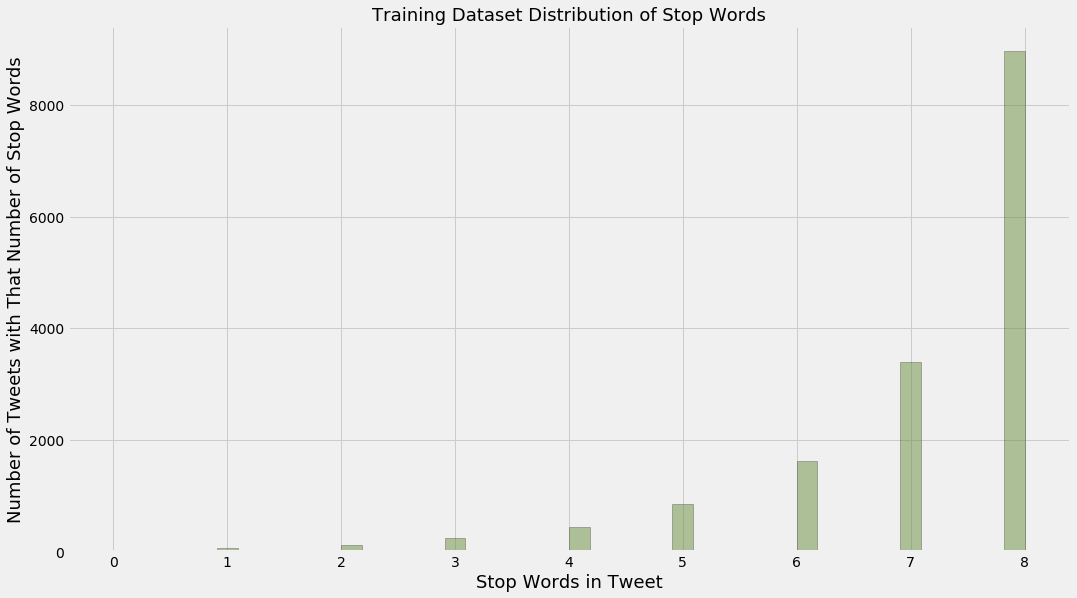

In [74]:
stop_words_mean = stop_words_data_for_stats.describe()["Stop words"][1]
stop_words_std = stop_words_data_for_stats.describe()["Stop words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(stop_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#698f3f",
                           alpha=0.5)

# stop_words_line = scipy.stats.norm.pdf(bins, stop_words_mean, stop_words_std)
# ax.plot(bins, stop_words_line, "--", linewidth=3, color="#87a565")

ax.set_title("Training Dataset Distribution of Stop Words", fontsize=18)
ax.set_xlabel("Stop Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Stop Words", fontsize=18)

plt.show()

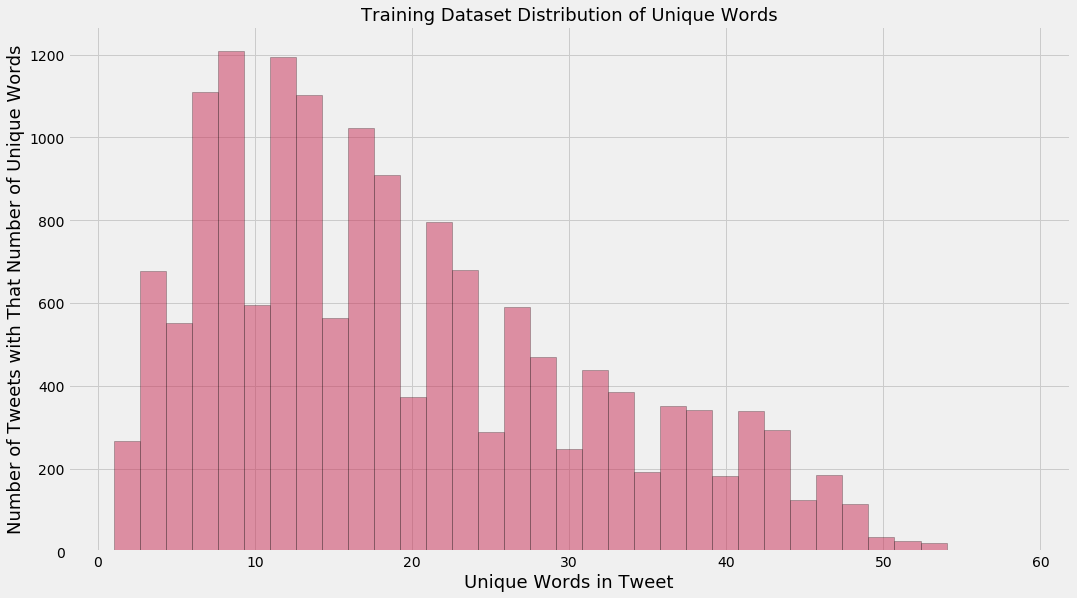

In [75]:
unique_words_mean = unique_words_data_for_stats.describe()["Unique words"][1]
unique_words_std = unique_words_data_for_stats.describe()["Unique words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(unique_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#ca2e55",
                           alpha=0.5)

# unique_words_line = scipy.stats.norm.pdf(bins, unique_words_mean, unique_words_std)
# ax.plot(bins, unique_words_line, "--", linewidth=3, color="#d45776")

ax.set_title("Training Dataset Distribution of Unique Words", fontsize=18)
ax.set_xlabel("Unique Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Unique Words", fontsize=18)

plt.show()